# Research of advertisements for the sale of apartments

At your disposal are data from the Yandex.Real Estate service - an archive of advertisements for the sale of apartments in St. Petersburg and neighboring settlements for several years. You need to learn how to determine the market value of real estate. Your job is to set the parameters. This will allow you to build an automated system: it will track anomalies and fraudulent activity.

For each apartment for sale, two types of data are available. The first ones are entered by the user, the second ones are obtained automatically based on cartographic data. For example, the distance to the center, airport, nearest park and pond.

P.s initially the project was executed in Russian, and only then it was translated into English using an auto-translator, so errors or untranslated sections are possible.

### First view

In [1]:
import warnings
import pandas as pd

In [2]:
warnings.simplefilter('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

data = pd.read_csv('/datasets/real_estate_data.csv', delimiter = '\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


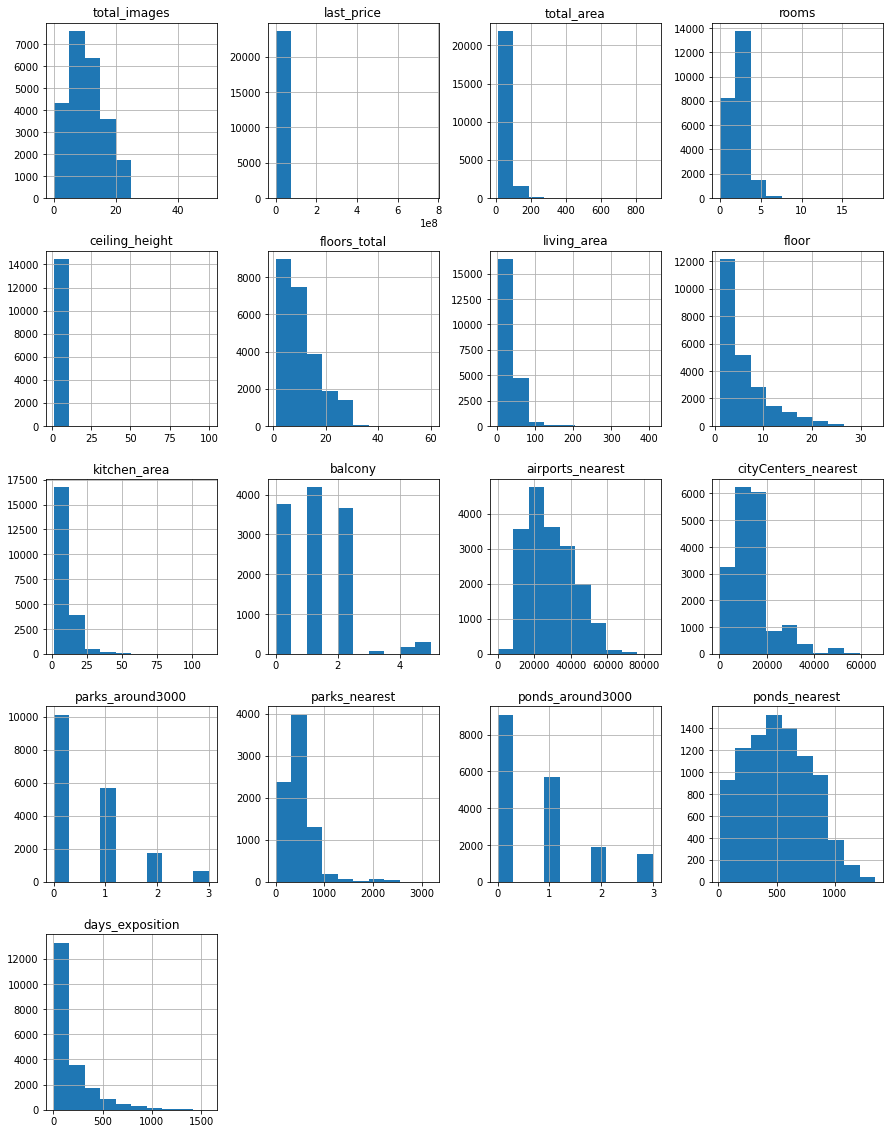

In [3]:
data.hist(figsize=(15, 20));

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.duplicated().sum()

0

There are no obvious duplicates

Let's calculate the percentage of gaps in each column

In [6]:
data.isna().mean()*100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
cityCenters_nearest     23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

Possible reasons for gaps in the first part of the table (the one that is filled in by the user) may be that the person simply did not enter information in the required field. As for those columns that contain cartographic information, there may be an error in the algorithms when obtaining data for the address.

**Intermediate output**

Some columns are missing values, such as ceiling_height, living_area, is_apartment, balcony, parks_nearest, and ponds_nearest. Therefore, you will need to clean the data and fill in missing values ​​before performing any analysis.

### Data preprocessing

**Processing Gaps**

In [7]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Since all missing values ​​may affect price, it is better to break down by price group as well as by location and then impute the missing values ​​based on group means rather than the entire sample at once.

Initially, we will remove prices that are too large (obviously abnormal) in order to more accurately divide them into groups.

In [8]:
data = data.drop(index= data.query('last_price > 20000000').index)

In [9]:
def price_group_func(data):
    length = len(data.last_price)
    data = data.sort_values(by = 'last_price').reset_index(drop = True)
    data['price_group'] = 0.500001+(data.index*10/length)
    data['price_group'] = pd.to_numeric(data['price_group'].round(), downcast = 'integer')
    return data

In [10]:
data = price_group_func(data)
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_group
0,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,1
1,7,430000.0,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,False,False,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,5,430000.0,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1
3,18,440000.0,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,NaN,False,False,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1
4,7,450000.0,42.0,2017-07-31T00:00:00,2,NaN,1.0,23.0,1,NaN,False,False,5.8,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0,1


Now we can fill in the gaps.

We will fill the missing values ​​in the "balcony" column with zero, since most likely the owner simply did not indicate its absence

In [11]:
data.balcony = data.balcony.fillna(0)

We will fill in the missing data about the location with the value “Other”, and when analyzing the location we will simply not take it into account.

In [12]:
data.locality_name.unique()

array(['Санкт-Петербург', 'Сланцы', 'посёлок станции Свирь',
       'деревня Старополье', 'городской посёлок Будогощь',
       'деревня Ям-Тесово', 'деревня Вахнова Кара', 'поселок Совхозный',
       'деревня Выскатка', 'деревня Бор', 'деревня Чудской Бор',
       'поселок городского типа Никольский', 'Пикалёво', 'Луга',
       'Бокситогорск', 'поселок Серебрянский', 'деревня Коркино',
       'поселок станции Вещево', 'Выборг', 'деревня Фалилеево',
       'посёлок Гаврилово', 'поселок Цвылёво', 'поселок Глажево',
       'деревня Торошковичи', 'посёлок городского типа Важины',
       'поселок Тёсово-4', 'Ивангород', 'поселок городского типа Вырица',
       'поселок городского типа Кондратьево', 'Тихвин', 'деревня Ялгино',
       'Светогорск', 'поселок городского типа Ефимовский',
       'поселок городского типа Синявино', 'поселок Володарское',
       'посёлок городского типа Кузнечное', 'деревня Малая Романовка',
       'Волхов', 'деревня Калитино', 'Гатчина', 'поселок Почап',
       '

In [13]:
data.locality_name = data.locality_name.fillna('Другое')

Let’s get rid of implicit duplicates in the location name column

In [14]:
data.locality_name = data.locality_name.str.replace('ё', 'е')

In [15]:
def location_maker(string):
    i = 0
    
    while True: 
        if string[i].islower() or string[i].isspace():
            string = string[1:]
        else:
            break
    return string
data.locality_name = data.locality_name.apply(location_maker)

In [16]:
data.locality_name.sort_values().unique()

array(['Агалатово', 'Александровская', 'Алексеевка', 'Аннино', 'Аро',
       'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Другое', 'Дружная Горка', 'Дружноселье',
       'Дубровка', 'Елизаветино', 'Ефимовский', 'Жилгородок',
       'Жилпоселок', 'Житково', 'Заводской', 'Заклинье', 'Заневка',
       'Запорожское', 'Зеленогорск', 'Зимитицы', 'Ивангород'

We will fill in the missing quantitative values ​​with the median values ​​of each group to which we assigned the object (i.e. by location and price group). in this way we will fill the gaps with data that should be as close as possible to the real ones. (It would also be nice to add noise so that later we don’t get candles on the histograms)

In [17]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby(['price_group', 'locality_name'])['ceiling_height'].transform('median'))
data['floors_total'] = data['floors_total'].fillna(data.groupby(['price_group', 'locality_name'])['floors_total'].transform('median'))
data['living_area'] = data['living_area'].fillna(data.groupby(['price_group', 'locality_name'])['living_area'].transform('median'))
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby(['price_group', 'locality_name'])['kitchen_area'].transform('median'))

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22992 entries, 0 to 22991
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          22992 non-null  int64  
 1   last_price            22992 non-null  float64
 2   total_area            22992 non-null  float64
 3   first_day_exposition  22992 non-null  object 
 4   rooms                 22992 non-null  int64  
 5   ceiling_height        22771 non-null  float64
 6   floors_total          22992 non-null  float64
 7   living_area           22950 non-null  float64
 8   floor                 22992 non-null  int64  
 9   is_apartment          2692 non-null   object 
 10  studio                22992 non-null  bool   
 11  open_plan             22992 non-null  bool   
 12  kitchen_area          22954 non-null  float64
 13  balcony               22992 non-null  float64
 14  locality_name         22992 non-null  object 
 15  airports_nearest   

There are still gaps in the data. Apparently some of the groups that we formed above still have empty values ​​because all the elements in this group are missing. Then we will fill the remaining gaps with the medians of the price groups.

In [19]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby(['price_group'])['ceiling_height'].transform('median'))
data['floors_total'] = data['floors_total'].fillna(data.groupby(['price_group'])['floors_total'].transform('median'))
data['living_area'] = data['living_area'].fillna(data.groupby(['price_group'])['living_area'].transform('median'))
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby(['price_group'])['kitchen_area'].transform('median'))

In [20]:
data.loc[data['floors_total'] < data['floor'], 'floors_total'] = data['floor']

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22992 entries, 0 to 22991
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          22992 non-null  int64  
 1   last_price            22992 non-null  float64
 2   total_area            22992 non-null  float64
 3   first_day_exposition  22992 non-null  object 
 4   rooms                 22992 non-null  int64  
 5   ceiling_height        22992 non-null  float64
 6   floors_total          22992 non-null  float64
 7   living_area           22992 non-null  float64
 8   floor                 22992 non-null  int64  
 9   is_apartment          2692 non-null   object 
 10  studio                22992 non-null  bool   
 11  open_plan             22992 non-null  bool   
 12  kitchen_area          22992 non-null  float64
 13  balcony               22992 non-null  float64
 14  locality_name         22992 non-null  object 
 15  airports_nearest   

We will remove the 'is_apartment' column from the data because it is missing almost 90% of the values

We will also change the format of the date column for further work with it

In [22]:
data = data.drop(columns = 'is_apartment')
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format = '%Y-%m-%dT%H:%M:%S')
data.balcony = pd.to_numeric(data.balcony, downcast = 'integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22992 entries, 0 to 22991
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22992 non-null  int64         
 1   last_price            22992 non-null  float64       
 2   total_area            22992 non-null  float64       
 3   first_day_exposition  22992 non-null  datetime64[ns]
 4   rooms                 22992 non-null  int64         
 5   ceiling_height        22992 non-null  float64       
 6   floors_total          22992 non-null  float64       
 7   living_area           22992 non-null  float64       
 8   floor                 22992 non-null  int64         
 9   studio                22992 non-null  bool          
 10  open_plan             22992 non-null  bool          
 11  kitchen_area          22992 non-null  float64       
 12  balcony               22992 non-null  int8          
 13  locality_name   

In [23]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_group
count,22992.000000,2.299200e+04,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,17472.000000,17489.000000,17490.000000,7574.000000,17490.000000,8594.000000,20008.000000,22992.000000
mean,9.779054,5.423607e+06,56.734944,2.010569,2.717348,10.745064,32.486902,5.896225,10.024533,0.592728,28851.585909,14495.345188,0.585592,493.823871,0.742081,524.360833,177.842763,5.499826
std,5.623933,3.220160e+06,24.810262,0.986324,1.002985,6.628381,16.453499,4.903312,4.593331,0.955454,12792.802950,8576.810577,0.781028,341.858035,0.918035,277.482414,216.461603,2.872374
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18427.000000,9815.000000,0.000000,289.250000,0.000000,303.000000,44.000000,3.000000
50%,9.000000,4.550000e+06,51.000000,2.000000,2.600000,9.000000,30.000000,4.000000,9.000000,0.000000,26820.000000,13277.000000,0.000000,456.000000,0.000000,510.000000,94.000000,5.500000
75%,14.000000,6.500000e+06,67.105000,3.000000,2.750000,16.000000,41.300000,8.000000,11.440000,1.000000,37434.000000,16464.000000,1.000000,614.000000,1.000000,734.000000,227.000000,8.000000
max,50.000000,2.000000e+07,460.800000,11.000000,100.000000,60.000000,279.600000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,10.000000


Note that in the 'rooms' column there are values ​​equal to 0. Most likely these are studio apartments.

In [24]:
display(len(data.query('rooms == 0')))
len(data.query('rooms == 0 and studio == True'))

196

138

Yes, indeed, most of these apartments are studios, but there is also something else. Let's look at the area of ​​these apartments, maybe they are also one-room.

In [25]:
display(data.query('rooms == 1').total_area.mean())
data.query('rooms == 0 and studio == False').total_area.max()

37.54604902936785

42.63

Almost the same, so let's set the number of rooms to 1

In [26]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

In [27]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_group
count,22992.000000,2.299200e+04,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,22992.000000,17472.000000,17489.000000,17490.000000,7574.000000,17490.000000,8594.000000,20008.000000,22992.000000
mean,9.779054,5.423607e+06,56.734944,2.019094,2.717348,10.745064,32.486902,5.896225,10.024533,0.592728,28851.585909,14495.345188,0.585592,493.823871,0.742081,524.360833,177.842763,5.499826
std,5.623933,3.220160e+06,24.810262,0.973142,1.002985,6.628381,16.453499,4.903312,4.593331,0.955454,12792.802950,8576.810577,0.781028,341.858035,0.918035,277.482414,216.461603,2.872374
min,0.000000,1.219000e+04,12.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18427.000000,9815.000000,0.000000,289.250000,0.000000,303.000000,44.000000,3.000000
50%,9.000000,4.550000e+06,51.000000,2.000000,2.600000,9.000000,30.000000,4.000000,9.000000,0.000000,26820.000000,13277.000000,0.000000,456.000000,0.000000,510.000000,94.000000,5.500000
75%,14.000000,6.500000e+06,67.105000,3.000000,2.750000,16.000000,41.300000,8.000000,11.440000,1.000000,37434.000000,16464.000000,1.000000,614.000000,1.000000,734.000000,227.000000,8.000000
max,50.000000,2.000000e+07,460.800000,11.000000,100.000000,60.000000,279.600000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,10.000000


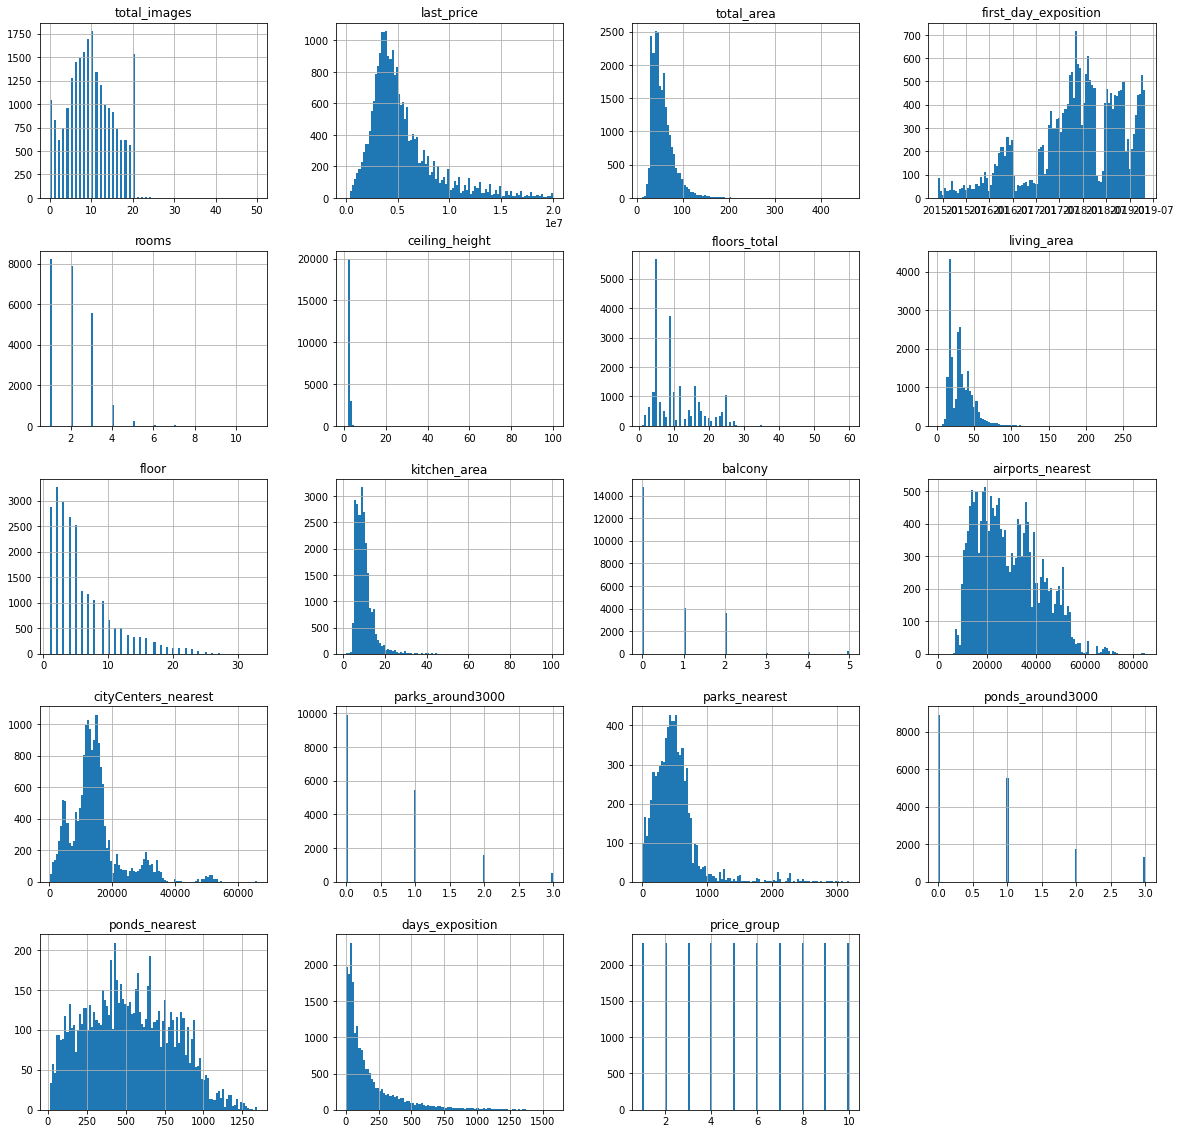

In [28]:
data.hist(bins = 100, figsize = (20,20));

Note that there are a lot of outliers in our data, so it is better to get rid of them before further analysis. Let's remove from the sample those elements whose values ​​exceed the deviation from the median in 2IQR.

In [29]:
def deleter(data):
    info = data.describe()
    indexes = []
    for column_name in ['last_price', 'total_area', 'rooms', 'ceiling_height']:
        iqr = data[column_name].describe().iloc[6]-data[column_name].describe().iloc[4]
        low_point = data[column_name].describe().iloc[4] - 1.5*iqr
        high_point = data[column_name].describe().iloc[6] + 1.5*iqr
        candidates = list(data.loc[(data[column_name] < low_point) | (data[column_name] > high_point)].index)
        indexes += candidates
       
    indexes = pd.Series([*indexes]).unique()
    print(f"было удалено {len(indexes)}({int(len(indexes)*100/len(data))}%) записей")
    data = data.drop(index= indexes)
    return data

In [30]:
data = deleter(data)

было удалено 2641(11%) записей


In [31]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_group
count,20351.000000,2.035100e+04,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,14971.000000,14982.000000,14983.000000,5959.000000,14983.000000,7039.000000,17950.000000,20351.000000
mean,9.654218,4.640572e+06,51.465026,1.886590,2.636565,10.981377,29.369418,5.990615,9.334376,0.604245,29114.860731,15435.501869,0.522259,495.252056,0.676433,536.355164,169.077493,5.028500
std,5.523351,2.026070e+06,16.673124,0.854249,0.130678,6.655815,11.878599,4.961657,3.476759,0.941497,13178.156863,8324.153296,0.738383,331.128907,0.863434,276.615650,207.145819,2.639927
min,0.000000,4.300000e+05,12.000000,1.000000,2.250000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,399.000000,0.000000,1.000000,0.000000,16.000000,1.000000,1.000000
25%,6.000000,3.265000e+06,38.400000,1.000000,2.540000,5.000000,18.000000,2.000000,7.000000,0.000000,17797.000000,11133.000000,0.000000,298.000000,0.000000,322.000000,43.000000,3.000000
50%,9.000000,4.300000e+06,48.000000,2.000000,2.600000,9.000000,28.600000,4.000000,8.800000,0.000000,27707.000000,13925.000000,0.000000,460.000000,0.000000,524.000000,90.000000,5.000000
75%,14.000000,5.700000e+06,62.000000,3.000000,2.700000,16.000000,37.500000,8.000000,10.900000,1.000000,38632.000000,16850.000000,1.000000,619.000000,1.000000,745.000000,213.000000,7.000000
max,50.000000,1.115000e+07,107.700000,6.000000,3.050000,60.000000,85.000000,33.000000,50.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,10.000000


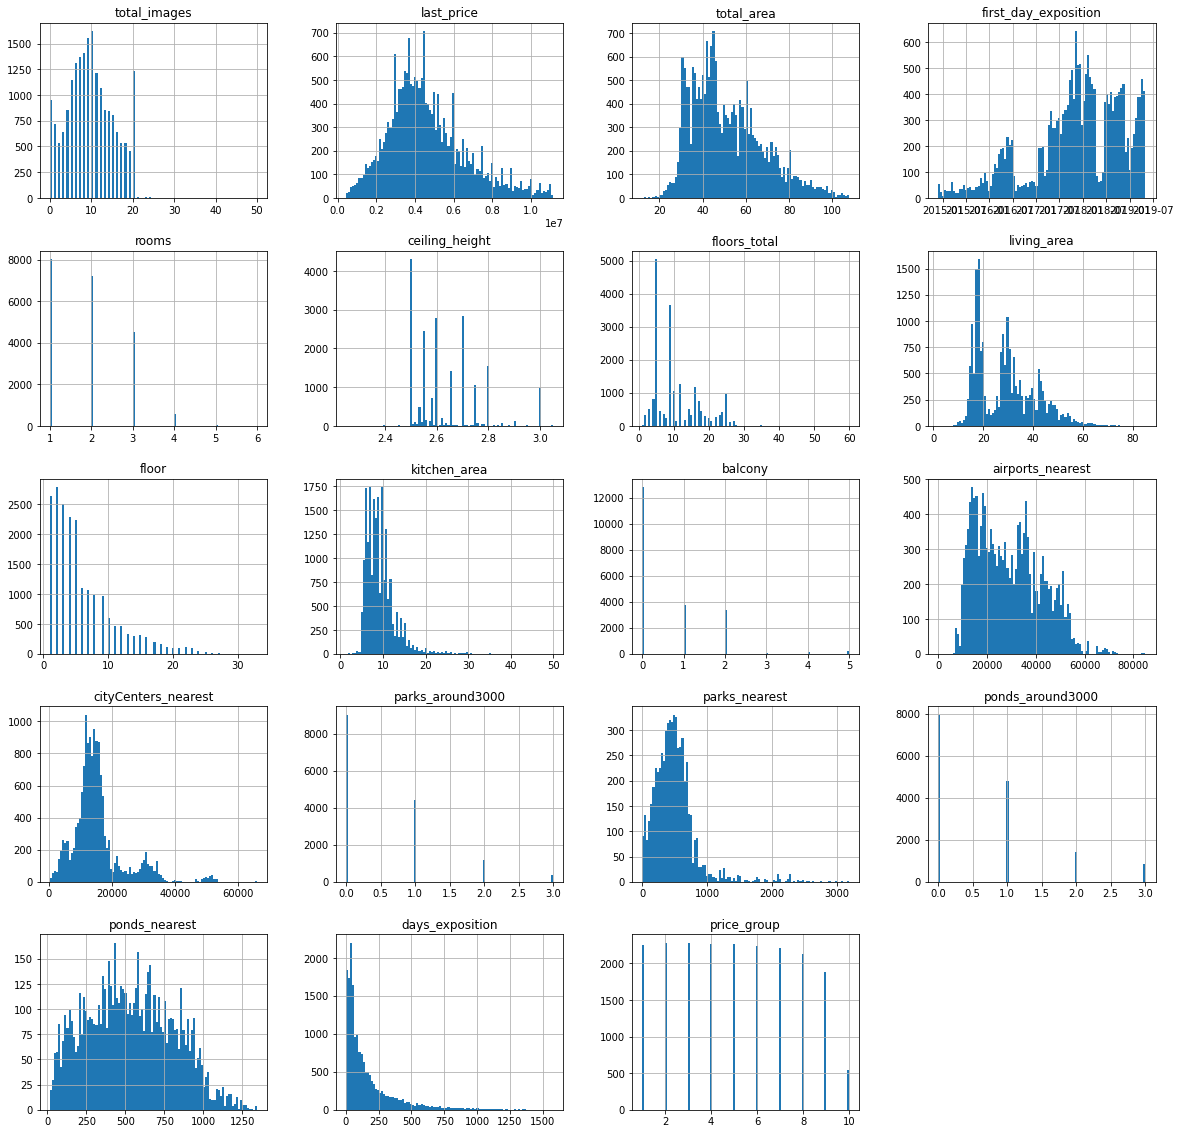

In [32]:
data.hist(bins = 100, figsize = (20,20));

In [33]:
data = data.sort_values('last_price').reset_index(drop = True)

The remaining observations fall within the range of normal values, so they can be considered relevant.
We also note how the shapes of our distributions changed and “candles” appeared (due to filling in the gaps with the median). Some of them have taken a more normal form, and now we can begin further work.

**Type of some columns**

In [34]:
data.floors_total = pd.to_numeric(data.floors_total, downcast = 'integer')
data.balcony = pd.to_numeric(data.balcony, downcast = 'integer')
data.parks_around3000 = pd.to_numeric(data.parks_around3000, downcast = 'integer')
data.ponds_around3000 = pd.to_numeric(data.ponds_around3000, downcast = 'integer')
data.days_exposition = pd.to_numeric(data.days_exposition, downcast = 'integer')

### New features

From the data obtained, new, more useful data can be obtained for analysis. For example price per square meter

In [35]:
data['square_price'] = (data['last_price']/data['total_area']).round(0)

We will also highlight the day of the week, month and year when the ad was created.

In [36]:
data['weekday'] = data['first_day_exposition'].dt.weekday

In [37]:
data['month'] = data['first_day_exposition'].dt.month

In [38]:
data['year'] = data['first_day_exposition'].dt.year

Let's add a grouping by floor type

In [39]:
data['floor_type'] = 0

In [40]:
data.loc[(data['floor'] == 1) & (data['floors_total'] != 1)  , 'floor_type'] = 'первый'
data.loc[(data['floor'] == data['floors_total']) & (data['floor'] != 1), 'floor_type'] = 'последний'
data.loc[data['floor_type'] == 0, 'floor_type'] = 'другой'

And finally, let's add the distance from the city center in a form more convenient for analysis.

In [41]:
data['center_dist_km'] = (data['cityCenters_nearest']/1000).round(decimals = 0)

Let's look at the resulting dataframe

In [42]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_group,square_price,weekday,month,year,floor_type,center_dist_km
0,7,430000.0,30.4,2019-04-22,1,2.500,2.0,16.0,1,False,False,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,14145.0,0,4,2019,первый,NaN
1,5,430000.0,54.0,2018-06-26,2,2.535,3.0,30.0,3,False,False,8.0,0,Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1,7963.0,1,6,2018,последний,NaN
2,18,440000.0,40.0,2018-07-10,1,2.535,5.0,30.3,1,False,False,5.5,0,Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1,11000.0,1,7,2018,первый,NaN
3,7,450000.0,42.0,2017-07-31,2,2.615,1.0,23.0,1,False,False,5.8,0,Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0,1,10714.0,0,7,2017,другой,NaN
4,0,450000.0,36.5,2018-02-01,1,2.535,5.0,17.3,4,False,False,8.5,1,Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1,12329.0,3,2,2018,другой,NaN


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20351 entries, 0 to 20350
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20351 non-null  int64         
 1   last_price            20351 non-null  float64       
 2   total_area            20351 non-null  float64       
 3   first_day_exposition  20351 non-null  datetime64[ns]
 4   rooms                 20351 non-null  int64         
 5   ceiling_height        20351 non-null  float64       
 6   floors_total          20351 non-null  float64       
 7   living_area           20351 non-null  float64       
 8   floor                 20351 non-null  int64         
 9   studio                20351 non-null  bool          
 10  open_plan             20351 non-null  bool          
 11  kitchen_area          20351 non-null  float64       
 12  balcony               20351 non-null  int8          
 13  locality_name   

###  Exploratory data analysis

**View data**

Let us consider the distributions of the main quantities

In [44]:
column_list = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 
               'ceiling_height', 'floor', 'floor_type', 'floors_total', 'center_dist_km', 
               'airports_nearest', 'parks_nearest', 'first_day_exposition']

count    20351.000000
mean        51.465026
std         16.673124
min         12.000000
25%         38.400000
50%         48.000000
75%         62.000000
max        107.700000
Name: total_area, dtype: float64

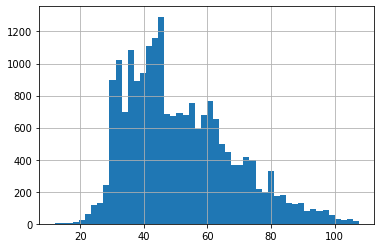

In [45]:
display(data.total_area.describe());
data.total_area.hist(bins = 50);

We can conclude that the distribution of areas of apartments for sale has a shape close to the normal distribution and averages 51 square meters. Most apartments range from 38 to 62 square meters. We also see a minimum of 12 square meters and a maximum of 107.7 square meters.

count    20351.000000
mean        29.369418
std         11.878599
min          2.000000
25%         18.000000
50%         28.600000
75%         37.500000
max         85.000000
Name: living_area, dtype: float64

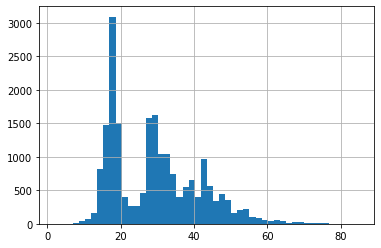

In [46]:
display(data.living_area.describe());
data.living_area.hist(bins = 50);

We see that the distribution of residential areas of apartments for sale has one pronounced peak of about 18 sq.m. (apparently appeared when filling in the blanks in the column), and the remaining values ​​are concentrated on an average of 28-29 square meters. Most apartments range from 18 to 37.5 square meters. We also see a minimum of 2 square meters and a maximum of 85 square meters.

count    20351.000000
mean         9.334376
std          3.476759
min          1.300000
25%          7.000000
50%          8.800000
75%         10.900000
max         50.000000
Name: kitchen_area, dtype: float64

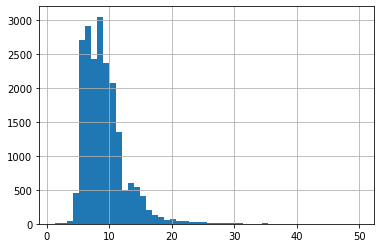

In [47]:
display(data.kitchen_area.describe());
data.kitchen_area.hist(bins = 50);

The distribution of kitchen areas in apartments for sale is positively skewed: the average value is 9 sq.m. and the median is 8.8 sq.m. Most kitchens are in the range of 7 to 11 sq.m. However, there are some apartments with very small or very large kitchen areas, as indicated by a minimum of 1.3 sq.m. and a maximum of 50 sq.m.

In [48]:
display(data.last_price.describe());

count    2.035100e+04
mean     4.640572e+06
std      2.026070e+06
min      4.300000e+05
25%      3.265000e+06
50%      4.300000e+06
75%      5.700000e+06
max      1.115000e+07
Name: last_price, dtype: float64

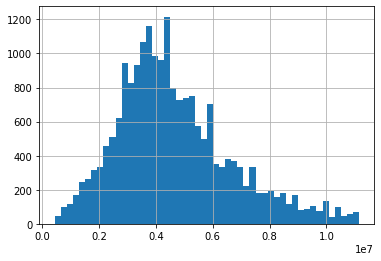

In [49]:
data.last_price.hist(bins = 50);

The distribution of prices for apartments put up for sale has a roughly normal shape. The average value is 4.64 million rubles. Most apartments fall in the range from 3.265 to 5.7 million rubles. However, there are several apartments with very low or very high prices, as evidenced by a minimum of 430,000 rubles and a maximum of 11.15 million rubles.

In [50]:
display(data.rooms.describe());

count    20351.000000
mean         1.886590
std          0.854249
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

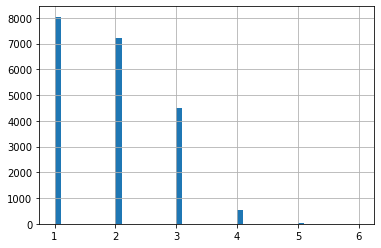

In [51]:
data.rooms.hist(bins = 50);

We see that most apartments have from 1 to 3 rooms, with a maximum of 6

count    20351.000000
mean         2.636565
std          0.130678
min          2.250000
25%          2.540000
50%          2.600000
75%          2.700000
max          3.050000
Name: ceiling_height, dtype: float64

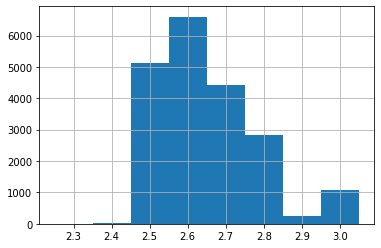

In [52]:
display(data.ceiling_height.describe());
data.ceiling_height.hist(bins = 8);

We can conclude that the distribution of ceiling heights across rooms of apartments for sale is relatively normal, with a mean of 2.636 meters and a median of 2.6 meters. Most apartments range from 2.54 to 2.7 meters, with a minimum ceiling height of 2.25 meters and a maximum of 3.05 meters.

count    20351.000000
mean         5.990615
std          4.961657
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

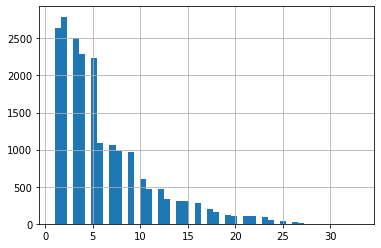

In [53]:
display(data.floor.describe());
data.floor.hist(bins = 50);

Based on the statistics provided, we can conclude that the distribution of apartments by floor is positively skewed, with a mean of 5.99 and a median of 4. Most apartments are located between the 2nd and 8th floors. The maximum floor is 33rd, but most apartments are located on the lower floors

count    20351.000000
mean        10.981377
std          6.655815
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

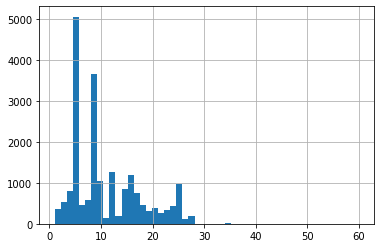

In [54]:
display(data.floors_total.describe());
data.floors_total.hist(bins = 50);

We see that most of the houses have 5, 9 or 16 floors (which is not surprising), but there are also 60-story buildings.

floor_type
другой       14966
первый        2612
последний     2773
Name: last_price, dtype: int64

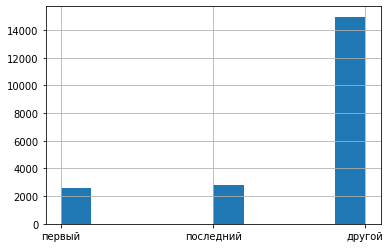

In [55]:
display(data.groupby('floor_type').last_price.count());
data.floor_type.hist();

About 25% of the apartments are located on the first or last floor, the remaining 75% are somewhere in between.

count    14982.000000
mean        15.432185
std          8.327425
min          0.000000
25%         11.000000
50%         14.000000
75%         17.000000
max         66.000000
Name: center_dist_km, dtype: float64

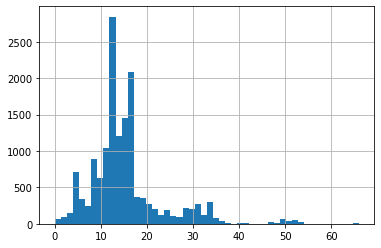

In [56]:
display(data.center_dist_km.describe());
data.center_dist_km.hist(bins = 50);

We can conclude that the distribution of apartments for sale by distance from the city center is approximately normal, with a mean of 15.43 km and a median of 14 km. The distance for most apartments is from 11 to 17 kilometers. However, there are some apartments right in the center (0 km), and some are as far away as 66 kilometers.

count    14971.000000
mean     29114.860731
std      13178.156863
min          0.000000
25%      17797.000000
50%      27707.000000
75%      38632.000000
max      84869.000000
Name: airports_nearest, dtype: float64

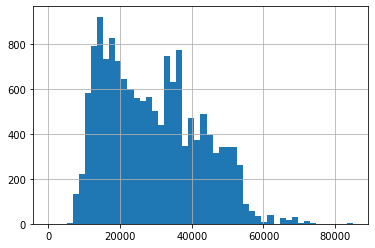

In [57]:
display(data.airports_nearest.describe());
data.airports_nearest.hist(bins = 50);

Based on the data provided, the average distance to the nearest airport is approximately 29,114 meters (or 29 kilometers). The minimum distance is 0 meters, which means that some apartments are located directly at or very close to the airport, while the maximum distance is 84,869 meters (or 84 kilometers), which indicates that some apartments are located quite far from airport.

count    5959.000000
mean      495.252056
std       331.128907
min         1.000000
25%       298.000000
50%       460.000000
75%       619.000000
max      3190.000000
Name: parks_nearest, dtype: float64

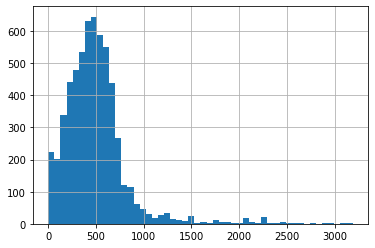

In [58]:
display(data.parks_nearest.describe());
data.parks_nearest.hist(bins = 50);

75% of apartments are located within 600 meters of the nearest park. This suggests that most apartments are located relatively close to the park, with only a small percentage located further away.

count    20351.000000
mean         2.583264
std          1.799436
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

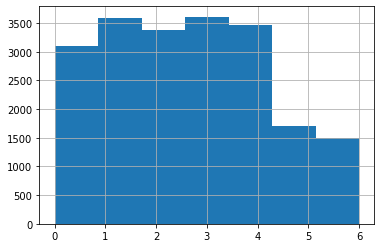

In [59]:
display(data.weekday.describe());
data.weekday.hist(bins = 7);

We see that most ads were posted on weekdays. Most likely this is due to the fact that most of it is laid out by realtors who do not work on weekends.

count    20351.000000
mean         6.396541
std          3.491611
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

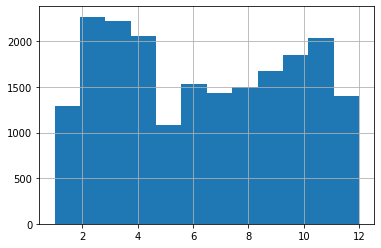

In [60]:
display(data.month.describe());
data.month.hist(bins = 12);

We see that mostly advertisements are posted either in early spring or towards the end of autumn. The rest of the time there is not so much activity.

count    20351.000000
mean      2017.391136
std          1.013825
min       2014.000000
25%       2017.000000
50%       2017.000000
75%       2018.000000
max       2019.000000
Name: year, dtype: float64

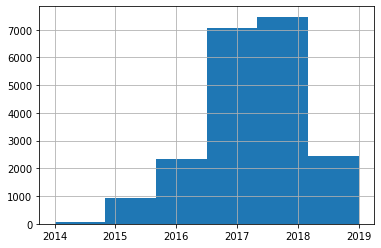

In [61]:
display(data.year.describe());
data.year.hist(bins = 6);

It is clearly visible that the number of advertisements is growing every year. This may indicate both an increase in the number of apartments being sold and an increase in the popularity of the service.

In [62]:
data[column_list].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,center_dist_km,airports_nearest,parks_nearest
count,20351.000000,20351.000000,20351.000000,2.035100e+04,20351.000000,20351.000000,20351.000000,20351.000000,14982.000000,14971.000000,5959.000000
mean,51.465026,29.369418,9.334376,4.640572e+06,1.886590,2.636565,5.990615,10.981377,15.432185,29114.860731,495.252056
std,16.673124,11.878599,3.476759,2.026070e+06,0.854249,0.130678,4.961657,6.655815,8.327425,13178.156863,331.128907
min,12.000000,2.000000,1.300000,4.300000e+05,1.000000,2.250000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,38.400000,18.000000,7.000000,3.265000e+06,1.000000,2.540000,2.000000,5.000000,11.000000,17797.000000,298.000000
50%,48.000000,28.600000,8.800000,4.300000e+06,2.000000,2.600000,4.000000,9.000000,14.000000,27707.000000,460.000000
75%,62.000000,37.500000,10.900000,5.700000e+06,3.000000,2.700000,8.000000,16.000000,17.000000,38632.000000,619.000000
max,107.700000,85.000000,50.000000,1.115000e+07,6.000000,3.050000,33.000000,60.000000,66.000000,84869.000000,3190.000000


In [63]:
data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['count'])

,count
,last_price
floor_type,
другой,14966
первый,2612
последний,2773


**Sales speed**

Let's see how quickly apartments sell, and also try to understand what sales can be considered fast or very long

count    17950.000000
mean       169.077493
std        207.145819
min          1.000000
25%         43.000000
50%         90.000000
75%        213.000000
max       1580.000000
Name: days_exposition, dtype: float64

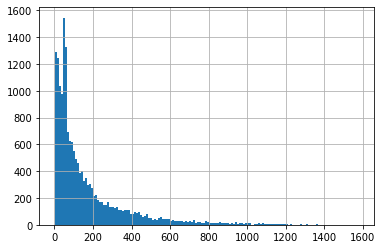

In [64]:
data.days_exposition.hist(bins = 150)

display(data.days_exposition.describe())

Based on the information provided, we can draw the following conclusions about the timing of the sale of apartments:

    -The average period for selling apartments is 169.

    -The minimum sales period is only 1 day, which means that some apartments are sold very quickly.

    -The median time to sell is 90 days, indicating that half of the apartments are sold within this period.

    -The maximum sales period is 1580 days, which means that the sale of some apartments takes a very long time.

In general, the time it takes for apartments to sell can vary greatly, with some selling very quickly and others taking much longer. The average selling time of 90 days suggests that the average apartment sale takes about 3 months.

To better understand what we can call an abnormally fast or abnormally long sale, let’s build a range diagram

<AxesSubplot:>

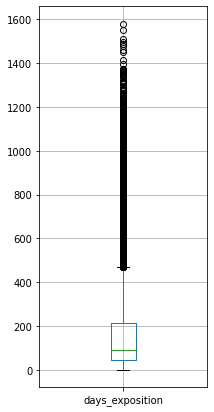

In [65]:
data.boxplot(column = 'days_exposition', figsize = (3,7)) 

We see many values ​​outside the scope of 2IQR. We can say that apartments sold during these periods were sold for an unusually long time (i.e., values ​​​​more than 468 are abnormal). Below there are no abnormally fast sales, but we can consider those sales that do not exceed the 0.25 quantile (i.e. faster than 43 days) to be fast.

**Factors influencing the price**

<AxesSubplot:title={'center':'total_area'}, xlabel='total_area', ylabel='last_price'>

<AxesSubplot:title={'center':'living_area'}, xlabel='living_area', ylabel='last_price'>

<AxesSubplot:title={'center':'kitchen_area'}, xlabel='kitchen_area', ylabel='last_price'>

<AxesSubplot:title={'center':'rooms'}, xlabel='rooms', ylabel='last_price'>

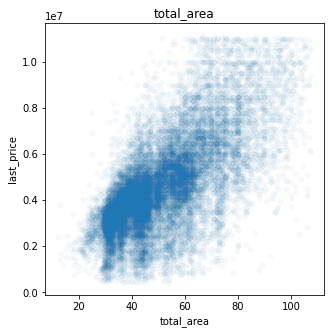

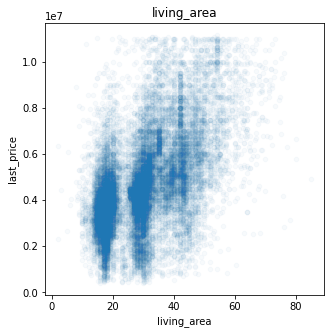

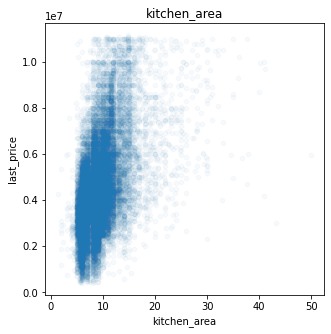

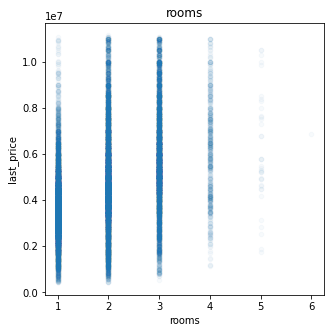

In [66]:
column_list = ['total_area', 'living_area', 'kitchen_area', 'rooms', ]
for column in column_list:
    display(data.plot(x=column, y='last_price',kind='scatter', alpha=0.03, title = column, figsize = (5,5)));

In [67]:
for column in column_list:
    print('Коэф. корреляции цены с', column, data.last_price.corr(data[column]))

Коэф. корреляции цены с total_area 0.6692674913040354
Коэф. корреляции цены с living_area 0.5405410683961966
Коэф. корреляции цены с kitchen_area 0.47854650125462644
Коэф. корреляции цены с rooms 0.4057315347599856


,другой,первый,последний,кол-во других,кол-во первый,кол-во последний,one
price_group,,,,,,,
1,1950000.0,0.877965,0.897436,1192,0.441275,0.452181,1
2,2850000.0,0.982456,0.982456,1528,0.248691,0.241492,1
3,3400000.0,0.997059,0.997059,1689,0.191829,0.159266,1
4,3800000.0,1.013158,1.000000,1671,0.171155,0.186715,1
5,4300000.0,0.999767,1.000000,1713,0.146527,0.175131,1
6,4850000.0,1.004124,0.989691,1734,0.145905,0.146482,1
7,5500000.0,1.000000,1.000000,1756,0.130979,0.130410,1
8,6500000.0,1.000000,0.998462,1725,0.106087,0.125217,1
9,8050000.0,0.981366,0.993789,1501,0.101932,0.151233,1


<AxesSubplot:xlabel='price_group'>

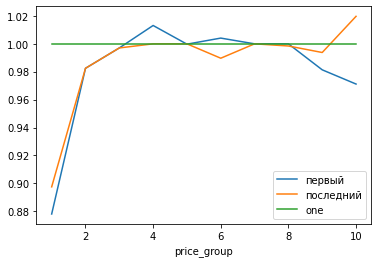

In [68]:
grouped_floors = data.pivot_table(index = 'price_group', columns = 'floor_type', values = 'last_price', aggfunc =  ['median', 'count'])
grouped_floors.columns = ['другой', 'первый', 'последний', 'кол-во других', 'кол-во первый', 'кол-во последний']
grouped_floors['one'] = 1
for column in ['первый', 'последний']:
    grouped_floors[column] =  grouped_floors[column]/grouped_floors['другой']
for column in ['кол-во первый', 'кол-во последний']:
    grouped_floors[column] =  grouped_floors[column]/grouped_floors['кол-во других']
display(grouped_floors)
display(grouped_floors.plot(y = ['первый', 'последний', 'one']))


<AxesSubplot:xlabel='weekday'>

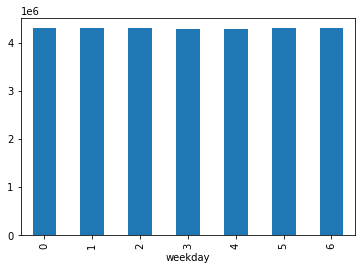

In [69]:
data.groupby('weekday').last_price.median().plot( kind = 'bar')

<AxesSubplot:xlabel='month'>

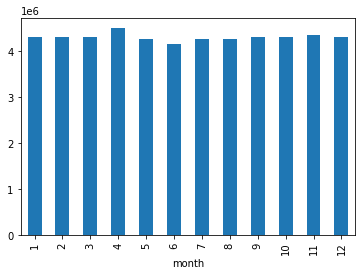

In [70]:
data.groupby('month').last_price.median().plot( kind = 'bar')

<AxesSubplot:xlabel='year'>

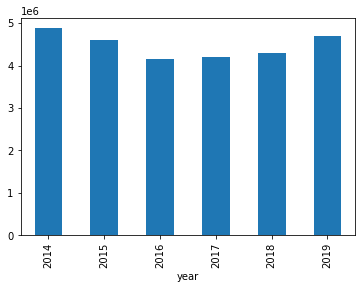

In [71]:
data.groupby('year').last_price.median().plot( kind = 'bar')

**Intermediate conclusion**

Based on the given correlation coefficients, we can conclude that there is a positive correlation between the price of an apartment and its various parameters. Specifically, the highest correlation is observed with total apartment area of ​​0.610, followed by living area of ​​0.487, kitchen area of ​​0.475 and number of rooms of 0.361.

This indicates that as these parameters increase, the price of the apartment also tends to increase. However, it is important to note that correlation does not necessarily imply causation.

Thus, although these correlation coefficients provide some insight into the relationship between the price of an apartment and various parameters, a comprehensive analysis that takes into account other factors is required to fully understand the price dynamics in the real estate market.

Regarding the type of floor on which the apartment is located, we see that mostly apartments on the top floor are cheaper than on others. This is especially noticeable in the lower price range. In the upper price range, the number of apartments falling into the “first” and “last” floor groups is greatly reduced, so we will not consider these data.

The day of the week and month when the ad was created, as expected, does not affect the price of the apartment. However, if we look at the year the ad was placed, we can see a drop in real estate prices closer to 2016, 2017, and then a gradual increase.

**Price per square meter**

Let's group the data by location and calculate the average cost per square meter.

In [72]:
grouped_square_price = data.pivot_table(index = 'locality_name', values = 'square_price',
                                        aggfunc = {'square_price':['mean', 'count']}
                                       ).sort_values( 'count', ascending = False)
display(grouped_square_price.head(10))
display(grouped_square_price.sort_values('mean').head(10))
grouped_square_price.sort_values(('mean'), ascending = False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,12670,104999.669455
Мурино,588,86064.818027
Кудрово,468,95148.177350
Шушары,432,78725.592593
Всеволожск,390,67161.687179
Колпино,325,75260.680000
Парголово,325,90417.175385
Пушкин,323,100181.715170
Гатчина,298,68606.986577


,count,mean
locality_name,,
Старополье,3,11206.333333
Свирь,2,11481.500000
Вахнова Кара,1,11688.000000
Выскатка,2,12335.500000
Совхозный,2,12629.500000
Малая Романовка,1,12725.000000
Тесово-4,1,12931.000000
Бор,1,13158.000000
Сижно,1,13710.000000


,count,mean
locality_name,,
Санкт-Петербург,12670,104999.669455
Зеленогорск,21,102890.380952
Сестрорецк,158,100720.284810
Лисий Нос,3,100661.000000
Пушкин,323,100181.715170
Мистолово,11,98550.000000
Левашово,1,96998.000000
Кудрово,468,95148.177350
Парголово,325,90417.175385


In the most popular places, the price per square meter ranges from 105,000 rubles/sq.m to 58,000 rubles/sq.m, but the main values ​​are about 80,000 rubles/sq.m.

We also see that the lowest rates are about 11,000 rubles/sq.m.

**Distance to center**

Let’s select apartments in St. Petersburg and immediately calculate the correlation coefficient between the distance from the center and the price of the property.

-0.2940654883847424

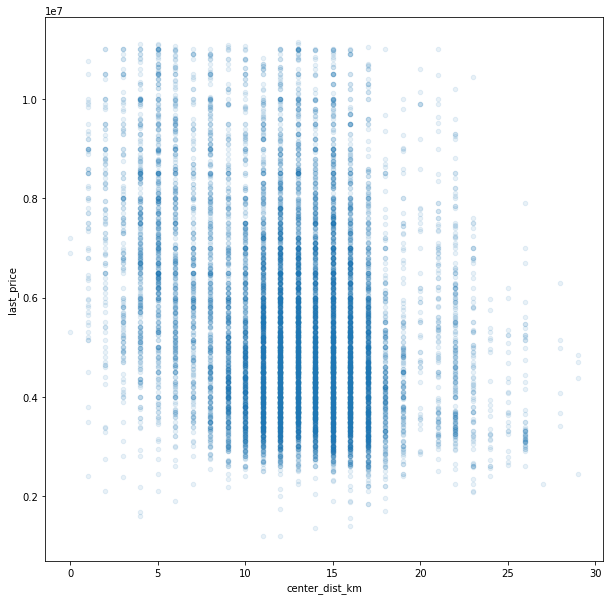

In [73]:
spb_flats = data.query('locality_name == "Санкт-Петербург"')
spb_flats.plot(x = 'center_dist_km', y = 'last_price', figsize = (10,10), kind = 'scatter', alpha = 0.1)
spb_flats.last_price.corr(spb_flats.center_dist_km)

This value indicates an unexpressed inverse relationship.

Let's do the same for the price per square meter.

-0.2959628874682706

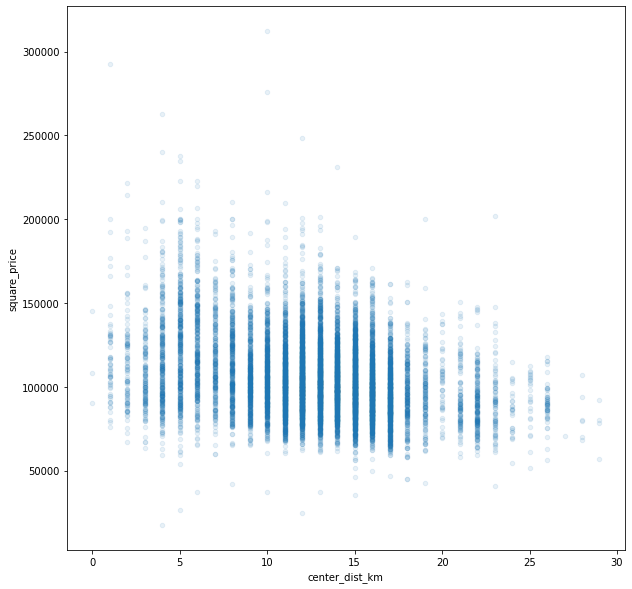

In [74]:
spb_flats.plot(x = 'center_dist_km', y = 'square_price', figsize = (10,10), kind = 'scatter', alpha = 0.1)
spb_flats.square_price.corr(spb_flats.center_dist_km)

Exactly the same: unexpressed inverse relationship.

Calculate the average price per kilometer

Цена за километр = 85989.39235190098


<AxesSubplot:xlabel='center_dist_km'>

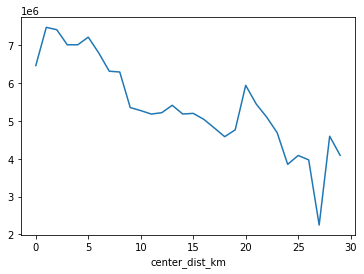

In [75]:
spb_flats_groupped = spb_flats.groupby('center_dist_km').last_price.mean()
print('Цена за километр =',  (((spb_flats_groupped[0]-spb_flats_groupped[26])/spb_flats.center_dist_km.max())) )
spb_flats_groupped.plot()

Цена за километр = 841.5090627763044


<AxesSubplot:xlabel='center_dist_km'>

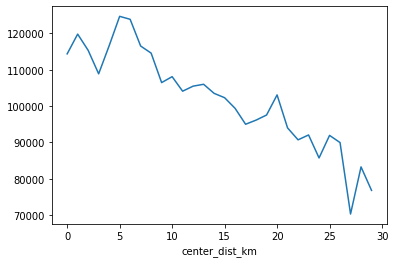

In [76]:
spb_flats_groupped = spb_flats.groupby('center_dist_km').square_price.mean()
print('Цена за километр =', (((spb_flats_groupped[0]-spb_flats_groupped[26])/spb_flats.center_dist_km.max())) )
spb_flats_groupped.plot()

**Intermediate conclusion**

It was possible to establish a relationship between the distance from the city center and the cost of the object. Each kilometer costs about 86 thousand rubles. or 841 rub/sq.m.

### General conclusion

Based on the information provided, we can conclude that there is a positive correlation between the price of an apartment and its various parameters such as total area, living area, kitchen area and number of rooms.

In St. Petersburg, we also see that distance from the city center has a significant impact on the cost of the property, with each kilometer costing approximately 86 thousand rubles. or 841 rub./sq.m.

The price per square meter varies widely, from 11,000 rubles/sq.m to 105,000 rubles/sq.m.

As for the timing, the average period for selling apartments is 169 days or about six months, with some apartments being sold in just a day, and some.

In general, buying or selling real estate requires analysis taking into account various factors, such as location and apartment parameters.